In [1]:
%%capture capt
!pip install matplotlib
!pip install pandas
!pip install seaborn
!pip install scikit-learn
!pip install chess
!pip install tensorflow
!pip install tensorflow_addons

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import Counter
import time
import seaborn as sns
import math

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

import chess

# Load data

In [3]:
%run S3.ipynb

In [4]:
#moves_df = pd.read_csv("../Data/moves_df.csv")
moves_df = open_csv("moves_df.csv")

In [5]:
moves_df

,game_index,moves,evaluation,fen,zobrist_key
0,0,e2e4,35,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,9384546495678726550
1,0,e7e5,48,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,595762792459712928
2,0,g1f3,111,rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQK...,15213300192948443293
3,0,b8c6,47,r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNB...,8704797333742910878
4,0,f1b5,52,r1bqkbnr/pppp1ppp/2n5/1B2p3/4P3/5N2/PPPP1PPP/R...,5409798013178080797
...,...,...,...,...,...
9023518,118318,a8c8,-6,2rq1rk1/pp2bppp/2n1pn2/3p4/8/P1NP1BP1/1P1BPP1P...,13935396515866781493
9023519,118318,f3g2,-2,2rq1rk1/pp2bppp/2n1pn2/3p4/8/P1NP2P1/1P1BPPBP/...,18028698229637126573
9023520,118318,a7a6,12,2rq1rk1/1p2bppp/p1n1pn2/3p4/8/P1NP2P1/1P1BPPBP...,2937820813377462641
9023521,118318,a1c1,25,2rq1rk1/1p2bppp/p1n1pn2/3p4/8/P1NP2P1/1P1BPPBP...,11978245410268853311


# Create board representations

### Functions

In [ ]:
%run board_representation.ipynb

### Multiprocessing

In [9]:
import multiprocessing
from multiprocessing import Pool

In [10]:
nb_cpu_cores = multiprocessing.cpu_count()

In [11]:
## we'll divide the fens into the nb of cpu cores we have, to use parallelize the creation of board representations

def get_starting_indices(len_data, divide_into):
    linspace = np.linspace(0, len_data, divide_into)
    indices = [math.floor(x) for x in linspace]
    return indices    

def get_lengths(len_data, indices):
    if len(indices) <= 1:
        return [len_data]
    lengths = [indices[1]]
    for i in range(2, len(indices)):
        lengths.append(indices[i]-indices[i-1])
    lengths.append(len_data-indices[-1])
    return lengths

In [12]:
def get_matrix_representations__subpart(all_fens, starting_index, length):
    fens = all_fens[starting_index:starting_index+length]
    X = np.zeros((len(fens), 8, 8, NB_OHE), dtype = np.uint8)
    for i, fen in enumerate(fens):
        X[i] = fen_to_matrix(fen)
    return X

def get_matrix_representations(df, total_size, divide_into=nb_cpu_cores):
    X = np.zeros((total_size, 8, 8, NB_OHE), dtype = np.uint8)
    fens = list(df.iloc[:total_size].fen)
    
    starting_indices = get_starting_indices(total_size, divide_into)
    lengths = get_lengths(total_size, starting_indices)

    with Pool() as pool:
        async_results = [pool.apply_async(get_matrix_representations__subpart,
                                        args = (fens.copy(), starting_indices[i], lengths[i])) for i in range(len(lengths))]

        for i in range(len(async_results)):
            start_index, length = starting_indices[i], lengths[i]
            #sub_X = async_results[i].get()
            X[start_index:start_index+length] = async_results[i].get()
    return X

In [13]:
total_size = 2_000_000
#total_size = len(moves_df)
fens = list(moves_df.fen)[:total_size]

In [14]:
start = time.time()

if __name__ == "__main__": 
    X = get_matrix_representations(moves_df, total_size, divide_into=nb_cpu_cores)

stop = time.time()
print(f"Creating X took {(stop-start)//60}m, {(stop-start)%60}s")

Creating X took 1.0m, 20.11159634590149s


In [15]:
import psutil
import sys
    
total_memory = psutil.virtual_memory().total 
X_size = sys.getsizeof(X)
print(f"X takes up {round(100 * X_size/total_memory, 2)}% of total memory")

X takes up 0.14% of total memory


### Split into train/val/test sets

In [16]:
y = np.array(moves_df.iloc[:total_size].evaluation)

In [17]:
def train_val_test(dataX, dataY, train_ratio=0.75, validation_ratio=0.15, test_ratio=0.10):
    if train_ratio+test_ratio+validation_ratio != 1:
        print("Ratios do not add up to 1")
    else:
        x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size=1 - train_ratio)
        x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

        return x_train, x_val, x_test, y_train, y_val, y_test

In [18]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test(X, y)

In [19]:
print(f"Training set shape : X_train -> {X_train.shape}, y_train -> {y_train.shape}")
print(f"Validation set shape : X_val -> {X_val.shape}, y_val -> {y_val.shape}")
print(f"Test set shape : X_test -> {X_test.shape}, y_train -> {y_test.shape}")

Training set shape : X_train -> (1500000, 8, 8, 12), y_train -> (1500000,)
Validation set shape : X_val -> (300000, 8, 8, 12), y_val -> (300000,)
Test set shape : X_test -> (200000, 8, 8, 12), y_train -> (200000,)


# Try Deep Learning

In [20]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import datasets, layers, models
from tensorflow_addons.metrics import RSquare
from tensorflow.keras import regularizers

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #remove warnings caused by tensorflow

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

2023-07-01 18:12:03.865351: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-01 18:12:03.921194: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-01 18:12:04.799120: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Version:  2.12.0
Eager mode:  True
GPU is available


In [21]:
kernel_regu = True

conv_0 = 512
conv_1 = 160

batch_norm_0 = False
dropout_0 = 0

dense_0 = 64
activation_0 = 'selu'

batch_norm_1 = False
dropout_1 = 0

add_dense_1 = False
dense_1 = 128
activation_1 = 'relu'

add_dense_2 = False
dense_2 = 64
activation_2 = 'relu'

batch_norm_2 = False
dropout_2 = 0

In [22]:
model = models.Sequential()

if kernel_regu:
    model.add(layers.Conv2D(conv_0, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(8, 8, NB_OHE)))
else:
    model.add(layers.Conv2D(conv_0, (3, 3), activation='relu', input_shape=(8, 8, NB_OHE)))
    
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(conv_1, (3, 3), activation='relu'))

model.add(layers.Flatten())

if batch_norm_0:
    model.add(layers.BatchNormalization())
model.add(layers.Dropout(dropout_0))

model.add(layers.Dense(dense_0, activation=activation_0))

if batch_norm_1:
    model.add(layers.BatchNormalization())
model.add(layers.Dropout(dropout_1))

if add_dense_1:
    model.add(layers.Dense(dense_1, activation=activation_1))

if add_dense_2:
    model.add(layers.Dense(dense_2, activation=activation_2))
    
if batch_norm_2:
    model.add(layers.BatchNormalization())
model.add(layers.Dropout(dropout_2))

model.add(layers.Dense(1))

2023-07-01 18:12:06.458524: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13154 MB memory:  -> device: 0, name: NVIDIA A2, pci bus id: 0000:17:00.0, compute capability: 8.6


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 6, 6, 512)         55808     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 512)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 64)                294976    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [24]:
initial_learning_rate = 1e-2
decay_steps = 1000
decay_rate = 0.9
# Define the learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate)

model.compile(loss=tf.keras.losses.MeanSquaredError(),
          optimizer=tf.keras.optimizers.Adam(
              #learning_rate=lr_schedule
              learning_rate = 1e-2
          ),
          metrics=[RSquare()])

In [25]:
filepath = 'model.h5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

es = EarlyStopping(monitor='val_loss', patience=8, verbose=1)

callbacks = [
            #es,
            checkpoint,
            ]

In [26]:
start=time.time()

history = model.fit(X_train, y_train, batch_size = 512, epochs=50, 
                    validation_data=(X_val, y_val), 
                    verbose=1, 
                    #callbacks=callbacks
                   )

stop=time.time()

Epoch 1/50


2023-07-01 18:12:56.525440: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-07-01 18:12:57.348739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-01 18:12:57.399363: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f36e4012320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-01 18:12:57.399435: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A2, Compute Capability 8.6
2023-07-01 18:12:57.412744: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-01 18:12:57.611387: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2930/2930 [==============================] - 48s 15ms/step - loss: 168866.2188 - r_square: 0.0756 - val_loss: 168549.6562 - val_r_square: 0.1155
Epoch 2/50
2930/2930 [==============================] - 43s 15ms/step - loss: 150963.5469 - r_square: 0.1751 - val_loss: 160676.4531 - val_r_square: 0.1582
Epoch 3/50
2930/2930 [==============================] - 43s 15ms/step - loss: 136867.9219 - r_square: 0.2536 - val_loss: 155745.9375 - val_r_square: 0.1852
Epoch 4/50
2930/2930 [==============================] - 43s 15ms/step - loss: 125644.4844 - r_square: 0.3160 - val_loss: 147707.6250 - val_r_square: 0.2284
Epoch 5/50
2930/2930 [==============================] - 43s 15ms/step - loss: 119124.8828 - r_square: 0.3526 - val_loss: 147619.0469 - val_r_square: 0.2296
Epoch 6/50
2930/2930 [==============================] - 42s 14ms/step - loss: 113465.6953 - r_square: 0.3844 - val_loss: 144352.1562 - val_r_square: 0.2475
Epoch 7/50
2930/2930 [==============================] - 43s 15ms/step - los

In [30]:
print(f"Took {round(stop-start, 2)}s to run. ")

Took 2141.33s to run. 


In [31]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    
def plot_history(history):
    plt.figure(figsize=(10, 7))
    plt.subplot(1, 2, 1)
    plot_graphs(history, 'loss')
    #plt.ylim(None, 1)
    plt.subplot(1, 2, 2)
    plot_graphs(history, 'r_square')
    #plt.ylim(0, None)
    plt.show()

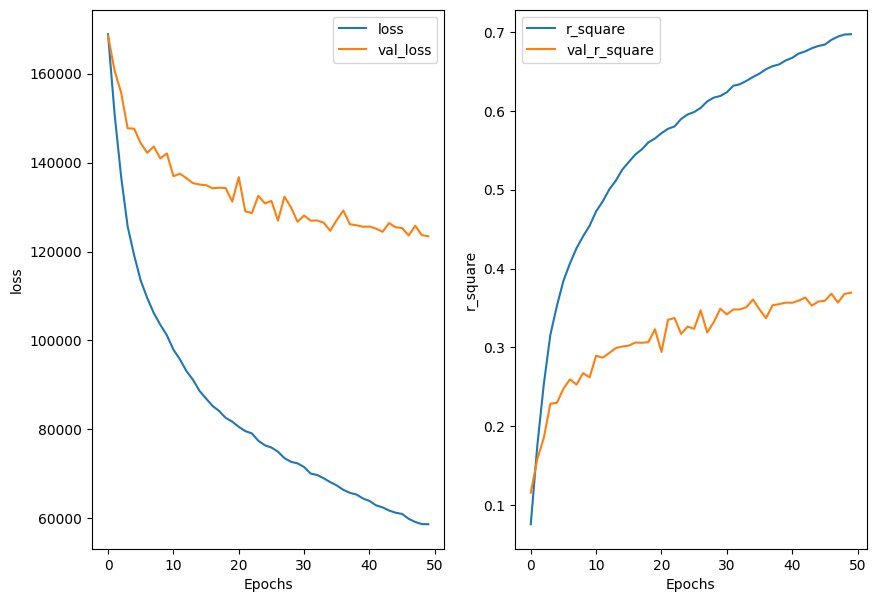

In [33]:
plot_history(history)

In [34]:
model.save("model.h5")

### Keras Tuner

Keras Tuner is the same idea as GridSearch, but in this case it is to try different NN designs to determine which one would be the best. 

In [27]:
%%capture capt
!pip install keras-tuner --upgrade

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

In [29]:
def build_model(hp):
    model = keras.Sequential()

    # 1. 1st Conv2D layer
    if hp.Boolean("kernelRegularizer"):
        model.add(layers.Conv2D(hp.Int('conv1_units', min_value=32, max_value=1024, step=32),
                                kernel_size=(3, 3),
                                activation='relu',
                                kernel_regularizer=regularizers.l2(0.01),
                                input_shape=(8, 8, NB_OHE)))
    else:
        model.add(layers.Conv2D(hp.Int('conv1_units', min_value=32, max_value=1024, step=32),
                                kernel_size=(3, 3),
                                activation='relu',
                                input_shape=(8, 8, NB_OHE)))

    # 2.  MaxPool layer
    model.add(layers.MaxPooling2D((2, 2)))

    # 3.  2nd Conv2D layer
    model.add(layers.Conv2D(hp.Int('conv2_units', min_value=32, max_value=256, step=32),
                            kernel_size=(3, 3),
                            activation='relu'))

    # 4.  Flatten layer
    model.add(layers.Flatten())

    # 5. BatchNormalization layer
    if hp.Boolean("batchNormalization1"):
        model.add(layers.BatchNormalization())

    # 6. Dropout layer
    if hp.Boolean("dropout1"):
        dropout_rate = hp.Float("dropout_rate1", min_value=0.2, max_value=0.5, step = 0.1)
        model.add(layers.Dropout(rate=dropout_rate))

    # 7. 1st Dense layer
    model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int("units_dense1", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation_dense1", ["elu", "selu", "relu"]),
            )
        )

    # 7. 2nd Dropout layer
    if hp.Boolean("dropout2"):
        dropout_rate = hp.Float("dropout_rate2", min_value=0.1, max_value=0.3, step = 0.1)
        model.add(layers.Dropout(rate=dropout_rate))

    # 8. 2nd BatchNormalization layer
    if hp.Boolean("batchNormalization2"):
        model.add(layers.BatchNormalization())
    
    # 9. Tune the number of dense layers
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_dense{i+1}", min_value=512, max_value=4096, step=128),
                activation=hp.Choice(f"activation_dense{i+1}", ["elu", "selu", "relu"]),
            )
        )

    # 10. 3rd Dropout layer
    if hp.Boolean("dropout3"):
        dropout_rate = hp.Float("dropout_rate3", min_value=0.2, max_value=0.4, step = 0.1)
        model.add(layers.Dropout(rate=dropout_rate))

    # 11. 3rd BatchNormalization layer
    if hp.Boolean("batchNormalization3"):
        model.add(layers.BatchNormalization())         

    # 12. Output layer
    model.add(layers.Dense(1))

    if hp.Boolean("lr_decay"):
        initial_learning_rate = 1e-2
        decay_steps = 1000
        decay_rate = 0.9
        # Define the learning rate schedule
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate, decay_steps, decay_rate)
    else:
        lr_schedule = hp.Float("lr", min_value=1e-5, max_value=1e-2, sampling="log")
        
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[RSquare()],
    )
    return model

In [30]:
tuner = RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    #max_trials=5,
    executions_per_trial=2,
    overwrite=True,
    directory="prediction_models",
    project_name="tuner_search_chess",
)

In [31]:
tuner.search_space_summary()

Search space summary
Default search space size: 14
kernelRegularizer (Boolean)
{'default': False, 'conditions': []}
conv1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
conv2_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
batchNormalization1 (Boolean)
{'default': False, 'conditions': []}
dropout1 (Boolean)
{'default': False, 'conditions': []}
units_dense1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation_dense1 (Choice)
{'default': 'elu', 'conditions': [], 'values': ['elu', 'selu', 'relu'], 'ordered': False}
dropout2 (Boolean)
{'default': False, 'conditions': []}
batchNormalization2 (Boolean)
{'default': False, 'conditions': []}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
dropout3 (Boolean)
{'default': F

In [32]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, verbose=1)
callbacks = [es]

In [ ]:
tuner.search(X_train, y_train, epochs=30, validation_data=(X_val, y_val))#, callbacks=callbacks)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
True              |True              |kernelRegularizer
512               |512               |conv1_units
160               |160               |conv2_units
False             |False             |batchNormalization1
False             |False             |dropout1
64                |64                |units_dense1
selu              |selu              |activation_dense1
False             |False             |dropout2
False             |False             |batchNormalization2
1                 |1                 |num_layers
True              |True              |dropout3
True              |True              |batchNormalization3
False             |False             |lr_decay
0.00045197        |0.00045197        |lr
0.2               |0.2               |dropout_rate3



2023-06-30 20:31:39.672821: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5197549056 exceeds 10% of free system memory.
2023-06-30 20:31:42.922458: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5197549056 exceeds 10% of free system memory.


Epoch 1/30
211489/211489 [==============================] - 1851s 9ms/step - loss: 174308.2031 - r_square: 0.1000 - val_loss: 173277.8438 - val_r_square: 0.1185
Epoch 2/30
211489/211489 [==============================] - 1838s 9ms/step - loss: 169578.4688 - r_square: 0.1245 - val_loss: 167382.3281 - val_r_square: 0.1486
Epoch 3/30
211489/211489 [==============================] - 1837s 9ms/step - loss: 167866.7500 - r_square: 0.1335 - val_loss: 165721.1562 - val_r_square: 0.1572
Epoch 4/30
211489/211489 [==============================] - 1832s 9ms/step - loss: 165324.2344 - r_square: 0.1468 - val_loss: 172379.1719 - val_r_square: 0.1235
Epoch 5/30
140980/211489 [==================>...........] - ETA: 9:29 - loss: 163488.0469 - r_square: 0.1589